In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import urllib.request
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3
3.6.5
2.6.0
1.3.3
1.2.0


In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

- 추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 
- 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

In [4]:
data.sample(10)

,headlines,text
67382,Asking 50 times won't change answer: Kriti on ...,"Kriti Sanon, while denying rumours of being in..."
82847,Steve Smith gets engaged to his girlfriend in ...,Australian skipper Steve Smith has gotten enga...
81218,SC orders nationwide stay on Centre's cattle s...,The Supreme Court on Tuesday put a stay on the...
58939,Trump uses racial slur while hosting Native Am...,US President Donald Trump on Monday used the t...
33729,"We shouted, driver was busy on phone: Kid in U...",A nine-year-old student who was injured in the...
26131,Nothing wrong: Hima Das on AFI's tweet about h...,"Hima Das, who became the first-ever Indian to ..."
3752,Empower those who need support: Kangana on Ran...,Actress Kangana Ranaut has responded to Rani M...
9482,14-yr-old dies in firing during enactment of K...,A 14-year-old boy was accidentally shot dead i...
61945,Bengaluru most conducive for digital transform...,Bengaluru has topped the list of global cities...
8465,Kapil Sharma confirms marriage with girlfriend...,Comedian Kapil Sharma took to Instagram to ann...


## 데이터 전처리

### 중복 샘플과 NULL 값 제거

In [5]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['headlines'], inplace=True)

data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


In [7]:
print(data.isnull().sum()) # 중복값이 없음을 확인

headlines    0
text         0
dtype: int64


### 텍스트 정규화와 불용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [9]:
import nltk
nltk.download('stopwords')

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [11]:
clean_headlines = []

for sentence in data['headlines']:  
    clean_headlines.append(preprocess_sentence(sentence, remove_stopwords = False))

# 전처리 후 출력
print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [12]:
clean_text = []

for sentence in data['text']: 
    clean_text.append(preprocess_sentence(sentence))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [13]:
data['headlines'] = clean_headlines
data['text'] = clean_text

data.replace('', np.nan, inplace = True)

In [14]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

Headline의 최소 길이 : 1
Headline의 최대 길이 : 16
Headline의 평균 길이 : 9.299444342675704
Text의 최소 길이 : 1
Text의 최대 길이 : 60
Text의 평균 길이 : 35.10029309397326


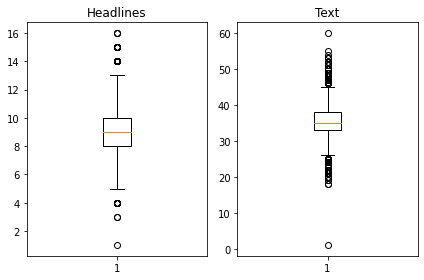

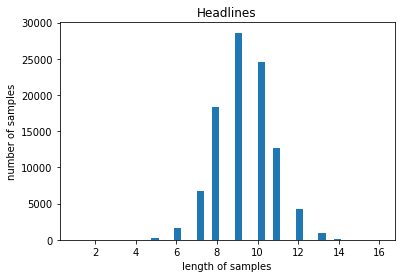

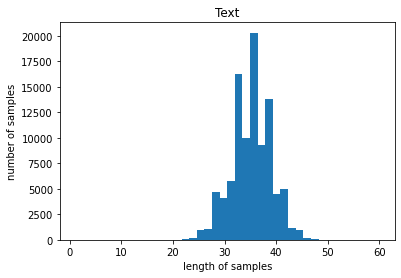

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headline_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('Headline의 최소 길이 : {}'.format(np.min(headline_len)))
print('Headline의 최대 길이 : {}'.format(np.max(headline_len)))
print('Headline의 평균 길이 : {}'.format(np.mean(headline_len)))
print('Text의 최소 길이 : {}'.format(np.min(text_len)))
print('Text의 최대 길이 : {}'.format(np.max(text_len)))
print('Text의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
headlines_max_len = 11
text_max_len = 43

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt += 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(headlines_max_len, data['headlines'])
below_threshold_len(text_max_len,  data['text'])

전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9450041725183692
전체 샘플 중 길이가 43 이하인 샘플의 비율: 0.9871669617960147


In [19]:
# 텍스트와 요약의 길이가 각각 headlines_max_len 및 text_max_len 작은 샘플들만 남기기
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]

# 결과 출력
print(f"제외 후 남은 샘플 수: {len(data)}")

제외 후 남은 샘플 수: 91679


### 시작 토큰과 종료 토큰 추가하기

In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
7,govt directs alok verma to join work day befor...,weeks ex cbi director alok verma told departme...,sostoken govt directs alok verma to join work ...,govt directs alok verma to join work day befor...


In [21]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [22]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

In [23]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [24]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 18335


In [25]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 73344
훈련 레이블의 개수 : 73344
테스트 데이터의 개수 : 18335
테스트 레이블의 개수 : 18335


In [26]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [27]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 67469
등장 빈도가 6번 이하인 희귀 단어의 수: 46058
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21411
단어 집합에서 희귀 단어의 비율: 68.26542560286947
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.633148517088199


In [28]:
src_vocab = 67000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 67000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [29]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4269, 2328, 625, 11, 1477, 456, 771, 147, 20011, 21412, 1, 230, 27, 2754, 1014, 534, 1123, 564, 724, 1599, 3, 13, 3519, 362, 3660, 449, 28, 636, 438, 600, 186, 724], [5, 6032, 103, 33695, 3164, 19, 9, 1550, 7652, 1174, 33696, 1606, 2684, 165, 3743, 4008, 945, 2970, 1587, 1793, 11113, 23206, 287, 6836, 1364, 1365, 13292, 33695, 1, 33696, 666, 628, 104, 8642, 462, 208], [71, 34, 12083, 1727, 232, 103, 28608, 294, 47, 12084, 2101, 2, 33697, 28608, 1262, 9867, 7534, 12083, 1727, 63, 33698, 3520, 209, 2088, 1898, 6, 6391, 546, 20012, 28608, 547, 11, 1201, 197, 1632, 7423, 7424, 33699, 33700, 23207, 28609, 43332]]


In [30]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [31]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29381
등장 빈도가 5번 이하인 희귀 단어의 수: 19282
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10099
단어 집합에서 희귀 단어의 비율: 65.62744630883904
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.960005814399522


In [32]:
tar_vocab = 29000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 229, 3818, 3, 60, 1590, 725, 57, 2429, 18966, 15038], [1, 27, 41, 3312, 4452, 1428, 3819, 11, 6577], [1, 800, 8499, 10101, 933, 529, 71, 157, 145], [1, 20, 3377, 137, 88, 3378, 2430, 530], [1, 3313, 6578, 17, 37, 3231, 6, 427, 496, 4055]]
target
decoder  [[229, 3818, 3, 60, 1590, 725, 57, 2429, 18966, 15038, 2], [27, 41, 3312, 4452, 1428, 3819, 11, 6577, 2], [800, 8499, 10101, 933, 529, 71, 157, 145, 2], [20, 3377, 137, 88, 3378, 2430, 530, 2], [3313, 6578, 17, 37, 3231, 6, 427, 496, 4055, 2]]


In [33]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 73344
훈련 레이블의 개수 : 73344
테스트 데이터의 개수 : 18335
테스트 레이블의 개수 : 18335


In [35]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

In [36]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h3, state_c3 = encoder_lstm3(encoder_output2)

# 최종 상태는 디코더로 전달됩니다.
state_h, state_c = state_h3, state_c3

In [37]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [38]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      8576000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [39]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 43)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 43, 128)      8576000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 43, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
287/287 [==============================] - 99s 315ms/step - loss: 6.6987 - val_loss: 6.0893
Epoch 2/50
287/287 [==============================] - 93s 323ms/step - loss: 6.1241 - val_loss: 5.8943
Epoch 3/50
287/287 [==============================] - 96s 336ms/step - loss: 5.8702 - val_loss: 5.6937
Epoch 4/50
287/287 [==============================] - 95s 332ms/step - loss: 5.6316 - val_loss: 5.5391
Epoch 5/50
287/287 [==============================] - 95s 332ms/step - loss: 5.4182 - val_loss: 5.3715
Epoch 6/50
287/287 [==============================] - 95s 331ms/step - loss: 5.1137 - val_loss: 5.0694
Epoch 7/50
287/287 [==============================] - 95s 331ms/step - loss: 4.7451 - val_loss: 4.7913
Epoch 8/50
287/287 [==============================] - 95s 331ms/step - loss: 4.3833 - val_loss: 4.6018
Epoch 9/50
287/287 [==============================] - 95s 331ms/step - loss: 4.0658 - val_loss: 4.4760
Epoch 10/50
287/287 [==============================] - 94s 328ms/step - l

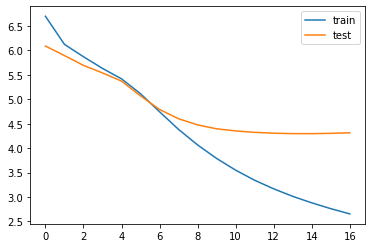

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [43]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [44]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [48]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [49]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i == 0):  
            continue
        if (i == tar_word_to_index['sostoken']):  
            continue
        if (i == tar_word_to_index['eostoken']):  
            break
        temp = temp + tar_index_to_word[i] + ' '  
    return temp.strip()

In [50]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : janata dal rebel leader sharad yadav tuesday removed chairman parliamentary standing committee industry reportedly due yadav alleged anti party activities stand jd chief nitish kumar decision ally bjp rcp singh close aide nitish kumar succeeded sharad yadav post 
실제 요약 : sharad yadav removed as chairman of parliamentary committee
예측 요약 :  jd leader quits as ram rajya sabha chief justice party


원문 : left arm fast bowler khaleel ahmed registered figures first ever odi hong kong tuesday coincidentally year old pacer idol zaheer khan also recorded figures debut kenya champions trophy want retire wicket zaheer ahmed jokingly said receiving team india call 
실제 요약 : ahmed posts same figures what his idol zaheer registered on debut
예측 요약 :  javagal srinath picked record for most int int cricket match


원문 : woman arrested allegedly forcing year old niece get drunk letting boyfriend rape wooded area delhi child father rushed hospital noticing bleeding pain aunt used take care child mother

In [51]:
import requests
from summa.summarizer import summarize

In [60]:
# str으로 변환
data['text'] = data['text'].astype(str)

In [63]:
def summarize_texts(df, column_name, ratio = 0.2):
    summarized_texts = []
    
    for text in df[column_name]:
        if isinstance(text, str) and len(text.strip()) > 0:  # 빈 문자열은 제외
            summary = summarize(text, ratio=ratio)
            summarized_texts.append(summary)
        else:
            summarized_texts.append("")  # 빈 값이거나 비문자열일 경우 빈 값 추가
    
    # 요약된 텍스트를 데이터프레임에 새로운 열로 추가
    df['summarized_' + column_name] = summarized_texts
    return df

In [64]:
df_summarized = summarize_texts(data, 'text', ratio=0.2)

In [65]:
print(df_summarized)

                                               headlines  \
0      upgrad learner switches to career in ml al wit...   
2      new zealand end rohit sharma led india match w...   
3      aegon life iterm insurance plan helps customer...   
5      rahat fateh ali khan denies getting notice for...   
7      govt directs alok verma to join work day befor...   
...                                                  ...   
98395  pakistan starts building fence along afghanist...   
98396  crpf jawan axed to death by maoists in chhatti...   
98397  first song from sonakshi sinha noor titled uff...   
98398              the matrix film to get reboot reports   
98400  madhesi morcha withdraws support to nepalese g...   

                                                    text  \
0      saurav kant alumnus upgrad iiit pg program mac...   
2      new zealand defeated india wickets fourth odi ...   
3      aegon life iterm insurance plan customers enjo...   
5      pakistani singer rahat fateh ali

In [66]:
def summarize_texts_by_words(df, column_name, word_limit=50):
    summarized_texts = []
    
    # 각 행의 텍스트를 요약하여 새로운 리스트에 추가
    for text in df[column_name]:
        if isinstance(text, str) and len(text.strip()) > 0:  # 빈 문자열 제외
            summary = summarize(text, words=word_limit)  # 단어 수로 요약
            summarized_texts.append(summary)
        else:
            summarized_texts.append("")  # 빈 값이거나 비문자열일 경우 빈 값 추가
    
    # 요약된 텍스트를 데이터프레임에 새로운 열로 추가
    df['summarized_' + column_name] = summarized_texts
    return df

In [68]:
df_summarized = summarize_texts_by_words(data, 'text', word_limit=50)

In [69]:
print(df_summarized)

                                               headlines  \
0      upgrad learner switches to career in ml al wit...   
2      new zealand end rohit sharma led india match w...   
3      aegon life iterm insurance plan helps customer...   
5      rahat fateh ali khan denies getting notice for...   
7      govt directs alok verma to join work day befor...   
...                                                  ...   
98395  pakistan starts building fence along afghanist...   
98396  crpf jawan axed to death by maoists in chhatti...   
98397  first song from sonakshi sinha noor titled uff...   
98398              the matrix film to get reboot reports   
98400  madhesi morcha withdraws support to nepalese g...   

                                                    text  \
0      saurav kant alumnus upgrad iiit pg program mac...   
2      new zealand defeated india wickets fourth odi ...   
3      aegon life iterm insurance plan customers enjo...   
5      pakistani singer rahat fateh ali

### 회고
- 어렵다 너무 어렵다. ㅋㅋ
- 재밌다 알아갈수록 재밌다. ㅎㅎ
- 나중에 NLP로 가야겠다.
- 정리할 게 많아져서 좋다.
- 추출적 요약에 대해 더 알아봐야겠다.